<a href="https://colab.research.google.com/github/shreyash53/SMAI-Knowledge-Distilation/blob/main/knowledge_distillation_MNIST_Distiller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


In [ ]:
# Create the teacher
teacher = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="teacher",
)

teacher.summary()



Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 256)       2560      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 256)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 512)         1180160   
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 10)                250890    
                                                           

In [ ]:
# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(100),
        # layers.Dropout(0.5),
        layers.Dense(50),
        # layers.Dropout(0.5),
        layers.Dense(10),
    ],
    name="student",
)

student.summary()

student_scratch = keras.models.clone_model(student)

In [ ]:
# Prepare the train and test dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))


In [ ]:
# Train teacher as usual
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate teacher on data.
teacher.fit(x_train, y_train, epochs=5)
teacher.evaluate(x_test, y_test)

Epoch 1/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1442 - sparse_categorical_accuracy: 0.9565
Epoch 2/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0919 - sparse_categorical_accuracy: 0.9731
Epoch 3/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0793 - sparse_categorical_accuracy: 0.9766
Epoch 4/5
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0726 - sparse_categorical_accuracy: 0.9799
Epoch 5/5
313/313 [==============================] - 2s 7ms/step - loss: 0.0802 - sparse_categorical_accuracy: 0.9787


[0.0802418664097786, 0.9786999821662903]

In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.2,
    temperature=3,
)

# Distill teacher to student
history1 = distiller.fit(x_train, y_train, validation_split=0.1, epochs=10)

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Epoch 1/10
1688/1688 [==============================] - 17s 10ms/step - sparse_categorical_accuracy: 0.8913 - student_loss: 0.4821 - distillation_loss: 0.3388 - val_sparse_categorical_accuracy: 0.9248 - val_student_loss: 0.0076
Epoch 2/10
1688/1688 [==============================] - 16s 10ms/step - sparse_categorical_accuracy: 0.9121 - student_loss: 0.4238 - distillation_loss: 0.2717 - val_sparse_categorical_accuracy: 0.9245 - val_student_loss: 0.0027
Epoch 3/10
1688/1688 [==============================] - 16s 10ms/step - sparse_categorical_accuracy: 0.9142 - student_loss: 0.4023 - distillation_loss: 0.2623 - val_sparse_categorical_accuracy: 0.9283 - val_student_loss: 0.0047
Epoch 4/10
1688/1688 [==============================] - 16s 9ms/step - sparse_categorical_accuracy: 0.9167 - student_loss: 0.3976 - distillation_loss: 0.2585 - val_sparse_categorical_accuracy: 0.9332 - val_student_loss: 0.0029
Epoch 5/10
1688/1688 [==============================] - 20s 12ms/step - sparse_categorica

[0.9128999710083008, 0.3029264211654663]

In [ ]:
# Train student as doen usually
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate student trained from scratch.
history = student_scratch.fit(x_train, y_train, validation_split=0.1, epochs=10)
student_scratch.evaluate(x_test, y_test)

Epoch 1/10
1313/1313 [==============================] - 7s 5ms/step - loss: 0.3848 - sparse_categorical_accuracy: 0.8896 - val_loss: 0.3240 - val_sparse_categorical_accuracy: 0.9086
Epoch 2/10
1313/1313 [==============================] - 6s 4ms/step - loss: 0.3132 - sparse_categorical_accuracy: 0.9104 - val_loss: 0.3044 - val_sparse_categorical_accuracy: 0.9134
Epoch 3/10
1313/1313 [==============================] - 7s 5ms/step - loss: 0.3011 - sparse_categorical_accuracy: 0.9134 - val_loss: 0.3045 - val_sparse_categorical_accuracy: 0.9177
Epoch 4/10
1313/1313 [==============================] - 7s 5ms/step - loss: 0.2924 - sparse_categorical_accuracy: 0.9172 - val_loss: 0.2994 - val_sparse_categorical_accuracy: 0.9181
Epoch 5/10
1313/1313 [==============================] - 7s 6ms/step - loss: 0.2869 - sparse_categorical_accuracy: 0.9176 - val_loss: 0.3165 - val_sparse_categorical_accuracy: 0.9146
Epoch 6/10
1313/1313 [==============================] - 6s 5ms/step - loss: 0.2830 - spars

[0.293090283870697, 0.9186000227928162]

In [ ]:
def plot_val_and_accuracy(history,history1):
  fig, ax = plt.subplots(1,2, figsize=(16, 6))
  ax[0].plot(history.history['val_loss'], color='r', label="Scratch Model loss")
  ax[0].plot(history1.history['val_student_loss'], color='b', label="Distillation Model loss",axes =ax[0])
  ax[0].set_title('Loss')
  legend = ax[0].legend(loc='best', shadow=True)

  ax[1].plot(history.history['val_sparse_categorical_accuracy'], color='r', label="Scratch Model Val accuracy")
  ax[1].plot(history1.history['val_sparse_categorical_accuracy'], color='b',label="Distillation Model Val accuracy")
  ax[1].set_title('Validation accuracy')
  legend = ax[1].legend(loc='best', shadow=True)
  plt.show()

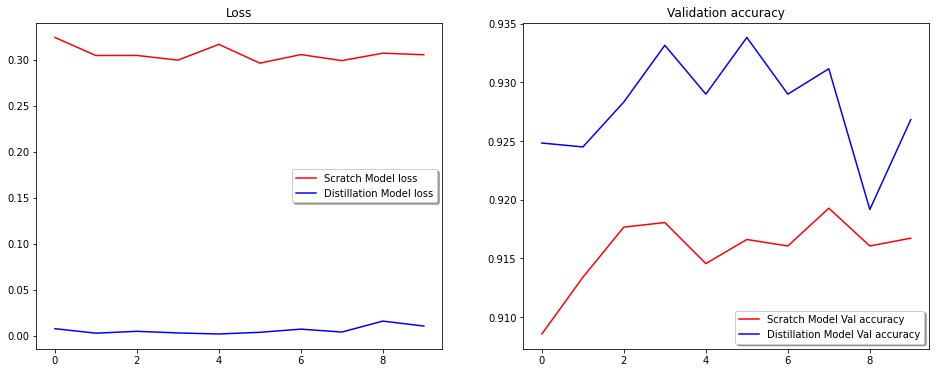

In [ ]:
plot_val_and_accuracy(history,history1)